In [3]:
# Import necessary libraries 

import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
import random
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# <span style= "color:red"> 0.Defining some audio utilities </span>


In [5]:
L=16000

In [74]:
# Function which chops an audiofile which is larger than 16000 samples (>1s) into 1s 
def chop_audio(samples, L=16000, num=50):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

# pad_audio will pad audios that are less than 16000(1 second) with 0s to make them all have the same length.        
def pad_audio(samples):
    return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

#label_transform transform labels into dummies values. It's used in combination with softmax to predict the label.
def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))


# <span style= "color:red"> 1. Examining directories and files </span>

### 1.1 Choose a file and read it in

In [61]:
train_audio_path = 'train/audio/'
test_audio_path = 'test/audio/'
test_audio_path_dep = 'test'

# Function which returns 
def getRandomFile(path,rand_seed):
  """
  Returns a random filename, chosen among the files of the given path.
  """
  random.seed(rand_seed)
  subdir_list=  [dir for dir in os.listdir(path) if isdir(join(path, dir))]
  if len(subdir_list)>0:
      dir_index= random.randrange(0,len(subdir_list))
      subdir = subdir_list[dir_index]  
      file_list = os.listdir(path+'/'+subdir)
      file_index = random.randrange(0, len(file_list))
      file = file_list[file_index]
      file_path=subdir+'/'+file
  
  else:
      file_list = os.listdir(path)
      file_index = random.randrange(0, len(file_list))
      file = file_list[file_index]
      file_path=file
    
  return file_path

def readaudiofile(path,random='yes',rand_seed=42,print_details='no'):
    if random=='yes':
        filename= getRandomFile(path,rand_seed)
        sample_rate, samples = wavfile.read(path + '/' + filename)
    else:
        filename=path
        sample_rate, samples = wavfile.read(path)
    if len(samples)>16000:
        samples_gen=chop_audio(samples)
        samples=next(samples_gen)
    elif len(samples)<16000:
        samples=pad_audio(samples)
    if print_details=='yes':    
        print("Sample Rate: "+str(sample_rate)+"\n")
        print("Output of Samples: "+ str(samples))
    return filename, samples, sample_rate

def readlibrosafile(path,random='yes',rand_seed=42,print_details='no'):
    if random=='yes':
        filename= getRandomFile(path,rand_seed)
        samples,sample_rate=librosa.load(path+ '/' + filename)
    else:
        filename=path
        samples,sample_rate=librosa.load(path)
    if len(samples)>16000:
        samples_gen=chop_audio(samples)
        samples=next(samples_gen)
    elif len(samples)<16000:
        samples=pad_audio(samples)
    if print_details=='yes':    
        print("Sample Rate: "+str(sample_rate)+"\n")
        print("Output of Samples: "+ str(samples))
    return filename, samples, sample_rate

In [51]:
# Read random file from train set 
print("Print random file from train set")
readaudiofile(train_audio_path,print_details='yes')

# Read random file from test set and display details
print("Print random file from test set")
readaudiofile(test_audio_path,print_details='yes')

Print random file from train set
Sample Rate: 16000

Output of Samples: [-18  10  58 ...  83  23 107]
Print random file from test set
Sample Rate: 16000

Output of Samples: [   5    7    9 ... -647 -612 -585]


('clip_2f3acb8db.wav',
 array([   5,    7,    9, ..., -647, -612, -585], dtype=int16),
 16000)

### 1.2 Examining number of labels and number of recordings   

In [10]:
# Calculate total number of recordings in train and test
def number_of_recordings(path):
    number_of_recordings_dict={}
    total_number_of_recordings=0
    subdir_list = [dir for dir in os.listdir(path) if isdir(join(path, dir))]
    if (len(subdir_list)==0):
        print("No sub-directories in this path"+"\n")
        print("Number of labels = "+str(0)+ "\n")
        file_list = [f for f in os.listdir(path) if f.endswith('.wav')]
        number_of_recordings_dict["unlabelled"]=len(file_list)
        total_number_of_recordings=len(file_list)
    else:   
        print("Number of labels =" + str(len(subdir_list))+ "\n")      
        for subdir in subdir_list:
            file_list = [f for f in os.listdir(join(path, subdir)) if f.endswith('.wav')]
            number_of_recordings_dict[subdir]=len(file_list)
            total_number_of_recordings+=len(file_list)
    return number_of_recordings_dict, total_number_of_recordings

print("Printing details about train set"+"\n")
train_number_of_recordings_dict, train_total_number_of_recordings=number_of_recordings(train_audio_path)
print("Number of recordings per label in train set: " + str(train_number_of_recordings_dict)+"\n")
print("Total number of recordings in train set: " + str(train_total_number_of_recordings)+"\n")

print("Printing details about test set"+"\n")
test_number_of_recordings_dict, test_total_number_of_recordings=number_of_recordings(test_audio_path)
print("Number of recordings per label in test set: " + str(test_number_of_recordings_dict)+"\n")
print("Total number of recordings in test set: " + str(test_total_number_of_recordings)+"\n")

# We can see that as expected the test set does not contain any labelled files

Printing details about train set

Number of labels =31

Number of recordings per label in train set: {'bed': 1713, 'bird': 1731, 'cat': 1733, 'dog': 1746, 'down': 2359, 'eight': 2352, 'five': 2357, 'four': 2372, 'go': 2372, 'happy': 1742, 'house': 1750, 'left': 2353, 'marvin': 1746, 'nine': 2364, 'no': 2375, 'off': 2357, 'on': 2367, 'one': 2370, 'right': 2367, 'seven': 2377, 'sheila': 1734, 'six': 2369, 'stop': 2380, 'three': 2356, 'tree': 1733, 'two': 2373, 'up': 2375, 'wow': 1745, 'yes': 2377, 'zero': 2376, '_background_noise_': 6}

Total number of recordings in train set: 64727

Printing details about test set

No sub-directories in this path

Number of labels = 0

Number of recordings per label in test set: {'unlabelled': 158538}

Total number of recordings in test set: 158538



#### Number of files in the background_noise folder are only 6 . Rest of the files are around 2000 per label 

### 1.3 Plotting number of recordings in different labels in train set

In [11]:
number_of_recordings_train_dict,_ = number_of_recordings(train_audio_path)
number_of_recordings_train_list = number_of_recordings_train_dict.items() # Converts the dictionary into a list of tuples
labels,numbers=zip(*number_of_recordings_train_list) # Unpacks the tuples and converts to two separate lists for plotting

data = [go.Histogram(x=labels, y=numbers)] # Using plotly to plot interactive plot
trace = go.Bar(x=labels,y=numbers)

layout = go.Layout(
    title='Number of recordings in given label in train set',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))

Number of labels =31



### 1.4 Figure out how many files are shorter than 1 second and how many are longer 

In [8]:
def num_of_shorter_longer(path):
    subdir_list = [dir for dir in os.listdir(path) if isdir(join(path, dir))]
    num_of_shorter = 0
    num_of_longer = 0
    for subdir in subdir_list:
        print("Currently looking in:" + str(subdir)) #This print statement was included because otherwise the code was hanging
        file_list = [f for f in os.listdir(join(path, subdir)) if f.endswith('.wav')]
        for file in file_list:
            sample_rate, samples = wavfile.read(path + subdir + '/' + file)
            if samples.shape[0] < sample_rate:
                num_of_shorter += 1
            elif samples.shape[0] > sample_rate:
                num_of_longer += 1
    return num_of_shorter, num_of_longer

In [9]:
num_of_shorter_train, num_of_longer_train = num_of_shorter_longer(train_audio_path)
print("Number of files shorter than 1 second: " + str(num_of_shorter_train) + "\n")
print("Number of files longer than 1 second: " + str(num_of_longer_train))

Currently looking in:bed
Currently looking in:bird
Currently looking in:cat
Currently looking in:dog
Currently looking in:down
Currently looking in:eight
Currently looking in:five
Currently looking in:four
Currently looking in:go
Currently looking in:happy
Currently looking in:house
Currently looking in:left
Currently looking in:marvin
Currently looking in:nine
Currently looking in:no
Currently looking in:off
Currently looking in:on
Currently looking in:one
Currently looking in:right
Currently looking in:seven
Currently looking in:sheila
Currently looking in:six
Currently looking in:stop
Currently looking in:three
Currently looking in:tree
Currently looking in:two
Currently looking in:up
Currently looking in:wow
Currently looking in:yes
Currently looking in:zero
Currently looking in:_background_noise_
Number of files shorter than 1 second: 6469

Number of files longer than 1 second: 6


C:\Users\Ravi\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\Ravi\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\Ravi\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\Ravi\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



### There are 6469 files in the train set which are less than 1 second long. We will have to pad them with 0s to ensure that the number of features are consistent across all files. The 6 files which are longer than 1 second likely belong to the __background_noise_ set

# <span style= "color:red"> 2. Visualizing raw audio files as well as using spectrograms and fft. Visualizing files in different domains </span>

### 2.1 Defining functions to compute spectrogram, fft etc. and visualize for EDA
Borrowed from https://www.kaggle.com/davids1992/data-visualization-and-investigation

In [77]:
# window_size and step_size considered in ms. nperseg and noverlap convert to samples per ms
# Add a small eps value to make sure log remains stable. I think librosa also implements similar spectrogram, log spectrogram functions
def log_specgram(audio_path, window_size=20,step_size=10, eps=1e-10,random='yes',rand_seed=42):
    filename,samples,sample_rate= readaudiofile(path=audio_path,random=random,rand_seed=rand_seed)
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(samples,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return filename,samples, sample_rate, freqs, times, np.log(spec.astype(np.float32) + eps)

def mel_specgram(audio_path,random='yes',rand_seed=42):
    filename, samples,sample_rate=readlibrosafile(path=audio_path,random=random,rand_seed=rand_seed)
    S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    return filename,samples,sample_rate,log_S


def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

def plot_raw_wave(audio_path,random='yes',rand_seed=42):
    filename,samples, sample_rate=readaudiofile(path=audio_path,random=random,rand_seed=rand_seed)
    fig = plt.figure(figsize=(14, 4))
    ax = fig.add_subplot(111)
    ax.set_title('Raw wave of ' + audio_path + '/'+ filename)
    ax.set_ylabel('Amplitude')
    ax.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

def plot_log_specgram(audio_path, window_size=20,step_size=10, eps=1e-10, random='yes',rand_seed=42):
    filename,samples, sample_rate, freqs,times,log_spec=log_specgram(audio_path,window_size,step_size,eps,random,rand_seed)
    fig = plt.figure(figsize=(14, 4))
    ax = fig.add_subplot(111)
    ax.imshow(log_spec, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax.set_yticks(freqs[::16])
    ax.set_xticks(times[::16])
    ax.set_title('Spectrogram of ' + audio_path + '/'+ filename)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')
    
def plot_mel_specgram (audio_path,random='yes',rand_seed=42):
    filename,samples,sample_rate, log_S=mel_specgram(audio_path,random,rand_seed)
    plt.figure(figsize=(14, 4))
    librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title('Mel power spectrogram ')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

    
def plot_custom_fft(audio_path,random='yes',rand_seed=42):
    filename,samples, sample_rate=readaudiofile(audio_path,random,rand_seed)
    xf, vals = custom_fft(samples, 16000)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

In [12]:
#Creating list of different labels
labels_list=list(labels)
target_word_list=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
silence_list=['_background_noise_']
unknown_label_list=[label for label in labels_list if label not in target_word_list and label not in silence_list]

### 2.2 FFT of a randomly selected file 

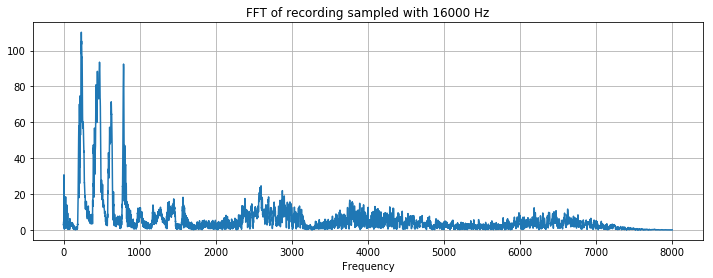

In [75]:
plot_custom_fft(train_audio_path) # FFT of randomly selected file from train set, Since sample rate is 16000, Nyquist frequency is 8000 Hz 

### 2.3 Log Spectrogram of a randomly selected file 

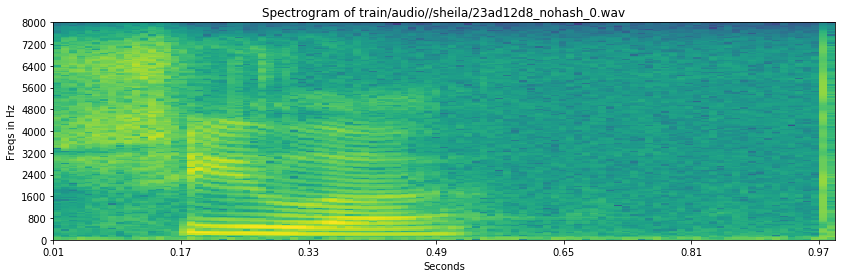

In [13]:
plot_log_specgram(train_audio_path)  # Randomly selected file from train set 

### 2.4 Mel Power Spectrogram of a randomly selected file 

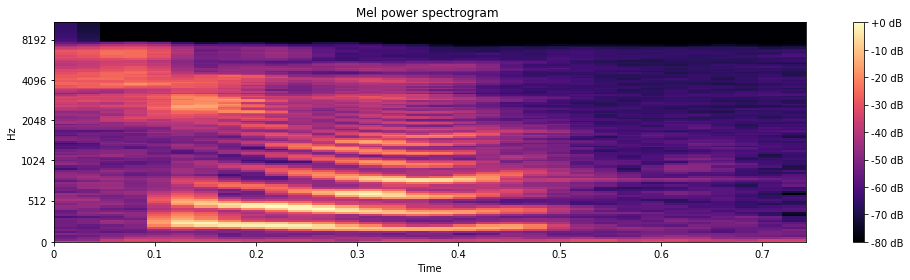

In [78]:
plot_mel_specgram(train_audio_path) # Mel Power Spectrogram of randomly selected file from train set 

### 2.5 Raw wave of a randomly selected file 

Sample Rate: 16000

Output of Samples: [-18  10  58 ...  83  23 107]


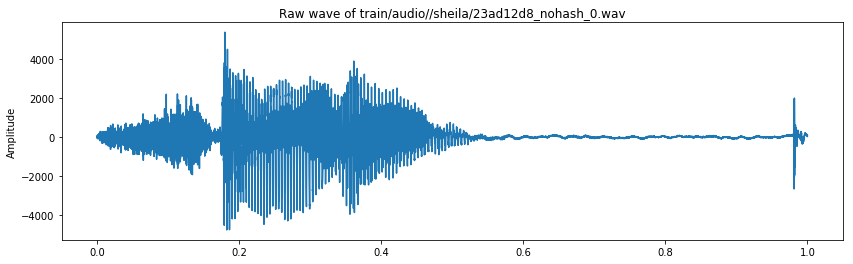

In [43]:
plot_raw_wave(train_audio_path)  # Raw wave of Randomly selected file from train set 

### 2.6 Raw Wave and Log Spectrogram of randomly selected Background Noise 

C:\Users\Ravi\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\Ravi\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Sample Rate: 16000

Output of Samples: [  34   15  -40 ...  -84 -109  -95]
Sample Rate: 16000

Output of Samples: [  10    1   48 ...  546   92 -464]


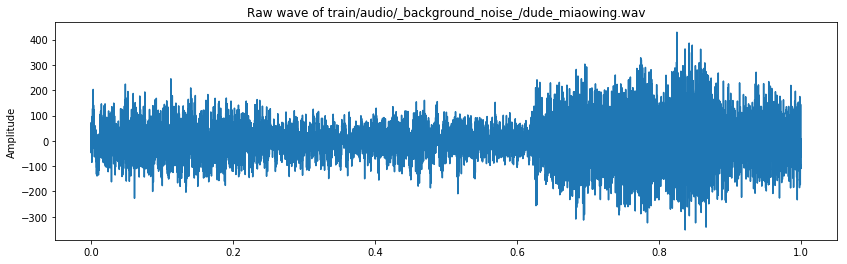

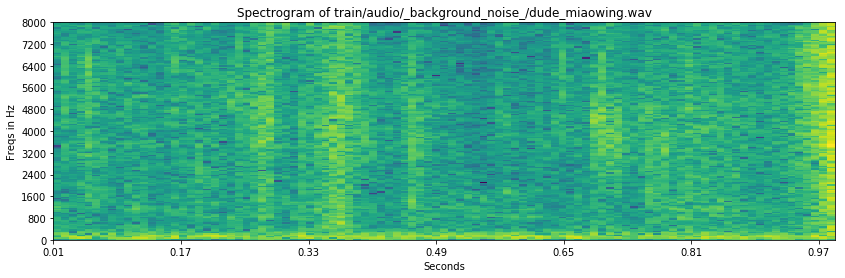

In [44]:
#Randomly selected file from subdirectory. In this case we visualize a randomly chosen file from "background_noise" subfolder
label_for_visualization= '_background_noise_' # User can change this 
label_path= train_audio_path+label_for_visualization
plot_raw_wave(label_path,rand_seed=100)

plot_log_specgram(label_path,rand_seed=100) 

# <span style= "color:red"> 3. Comparing spectrograms of different labels and different words in same label   </span>

### 3.1 Spectrogram of randomly selected file from each folder of the target_word_list 

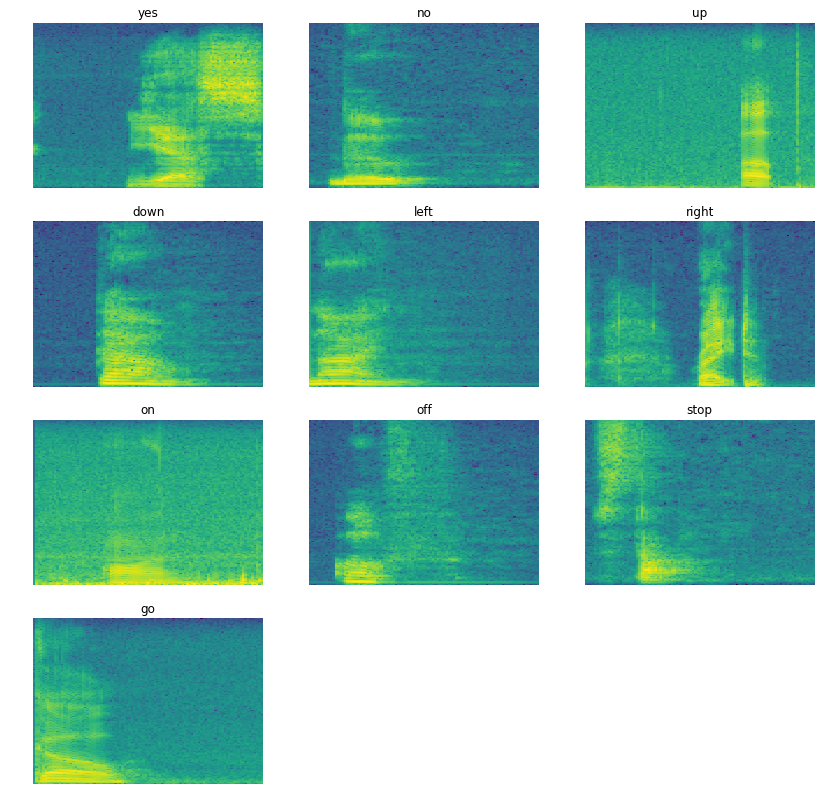

In [14]:
# Randomly selecting files from different folders of the target_word_list and plotting their log spectrogram 
fig = plt.figure(figsize=(14,14))

# for each of the samples
for i,label_for_visualization in enumerate(target_word_list):
    # Make subplots
    plt.subplot(4,3,i+1)
    label_path=train_audio_path+label_for_visualization
    filename,samples, sample_rate, freqs,times,log_spec=log_specgram(label_path)
    plt.imshow(log_spec, aspect='auto', origin='lower')
    plt.title(label_for_visualization)
    plt.axis('off')
     

### 3.2 Comparing Mel Power Spectograms of the same randomly selected files above  


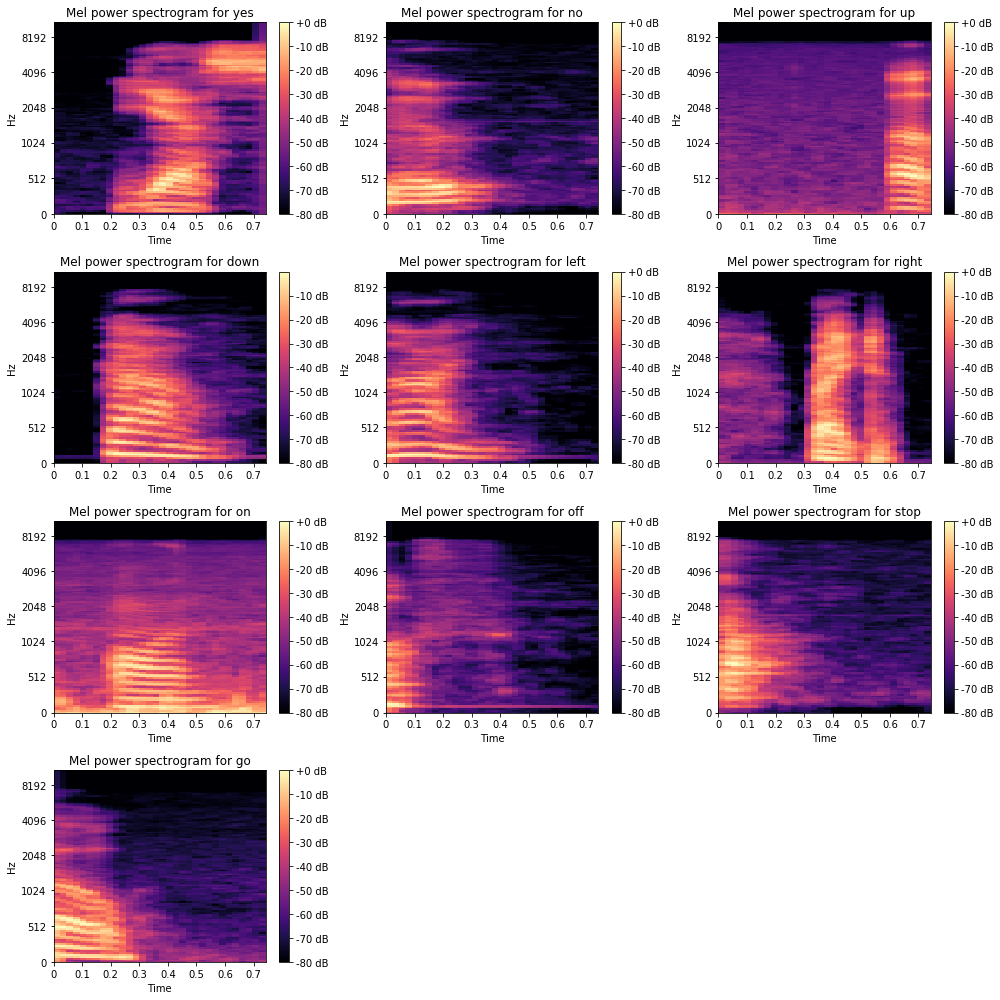

In [91]:
# Randomly selecting files from different folders of the target_word_list and plotting their log spectrogram 
fig = plt.figure(figsize=(14,14))

# for each of the samples
for i,label_for_visualization in enumerate(target_word_list):
    # Make subplots
    plt.subplot(4,3,i+1)
    label_path=train_audio_path+label_for_visualization
    filename,samples, sample_rate, log_S=mel_specgram(label_path)
    librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title('Mel power spectrogram for ' + label_for_visualization)
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

### 3.3 Comparing Raw wave of the same randomly selected files above  

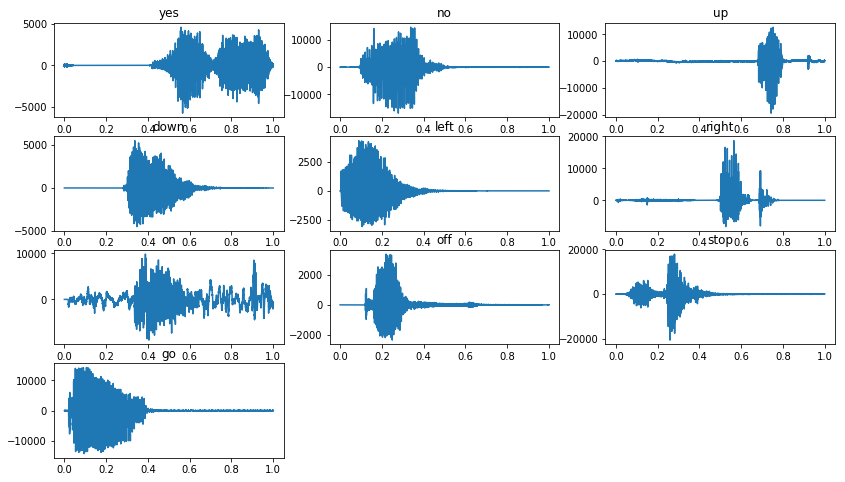

In [39]:
# Randomly selecting files from different folders of the target_word_list and plotting their raw waveforms 

fig = plt.figure(figsize=(14,8))
for i,label_for_visualization in enumerate(target_word_list):
    # Make subplots
    plt.subplot(4,3,i+1)
    label_path=train_audio_path+label_for_visualization
    filename,samples, sample_rate=readaudiofile(label_path)
    plt.title(label_for_visualization)
    plt.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
     

### 3.4 Spectrogram of 9 randomly selected files from one specific folder (corresponding to a specific label) 

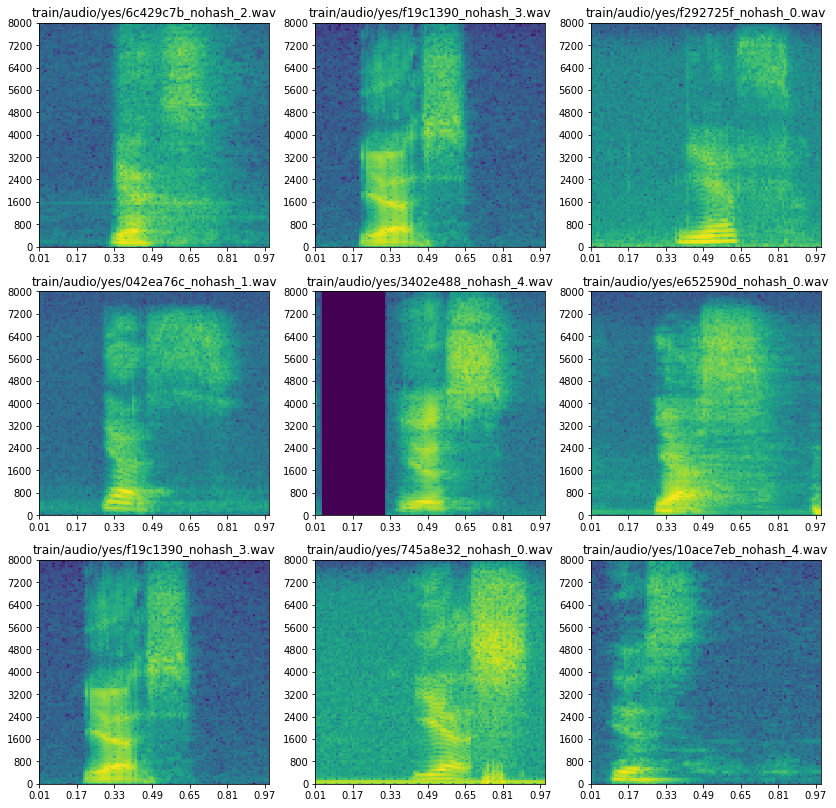

In [80]:
# Randomly selecting files belonging to same label 'yes' and plotting their spectrogramse 

fig = plt.figure(figsize=(14,14))
rand_int_list=[]
for i in range(9):
    rand_int_list.append(random.randint(0,100))
label_for_visualization='yes'        

for i,rand_seed in enumerate(rand_int_list):
    # Make subplots
    plt.subplot(3,3,i+1)
    label_path=train_audio_path+label_for_visualization
    filename,samples, sample_rate, freqs,times,log_spec=log_specgram(label_path,rand_seed=rand_seed)
    plt.imshow(log_spec, aspect='auto', origin='lower',extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.title(label_path+'/'+filename)
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])


### 3.5 Spectrogram of same 9 files as above but with normalized log spectrogram.
Display does not change because all the images have just been normalized. Not sure if this may be better input to NN

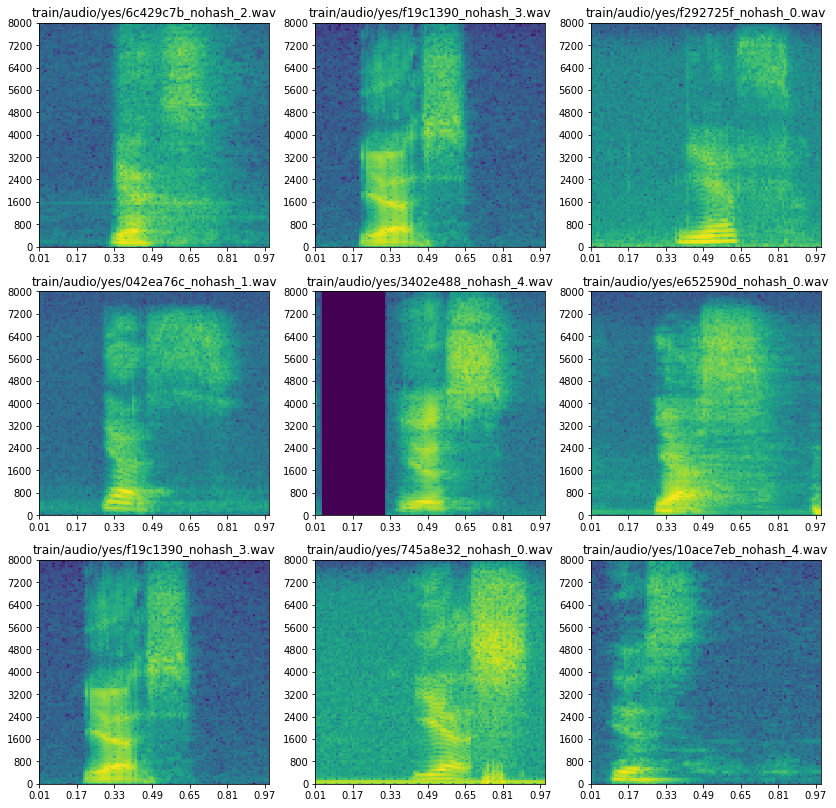

In [83]:
# Randomly selecting files belonging to same label and plotting their spectrogramse AFTER NORMALIZATION (Not sure about this)

fig = plt.figure(figsize=(14,14))
       

for i,rand_seed in enumerate(rand_int_list):
    # Make subplots
    plt.subplot(3,3,i+1)
    label_path=train_audio_path+label_for_visualization
    filename,samples, sample_rate, freqs,times,log_spec=log_specgram(label_path,rand_seed=rand_seed)
    mean = np.mean(log_spec)
    std = np.std(log_spec)
    log_spec_mean = (log_spec - mean) / std
    plt.imshow(log_spec_mean, aspect='auto', origin='lower',extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.title(label_path+'/'+filename)
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])

### 3.6 Mel Power Spectrogram of same 9 files as above 


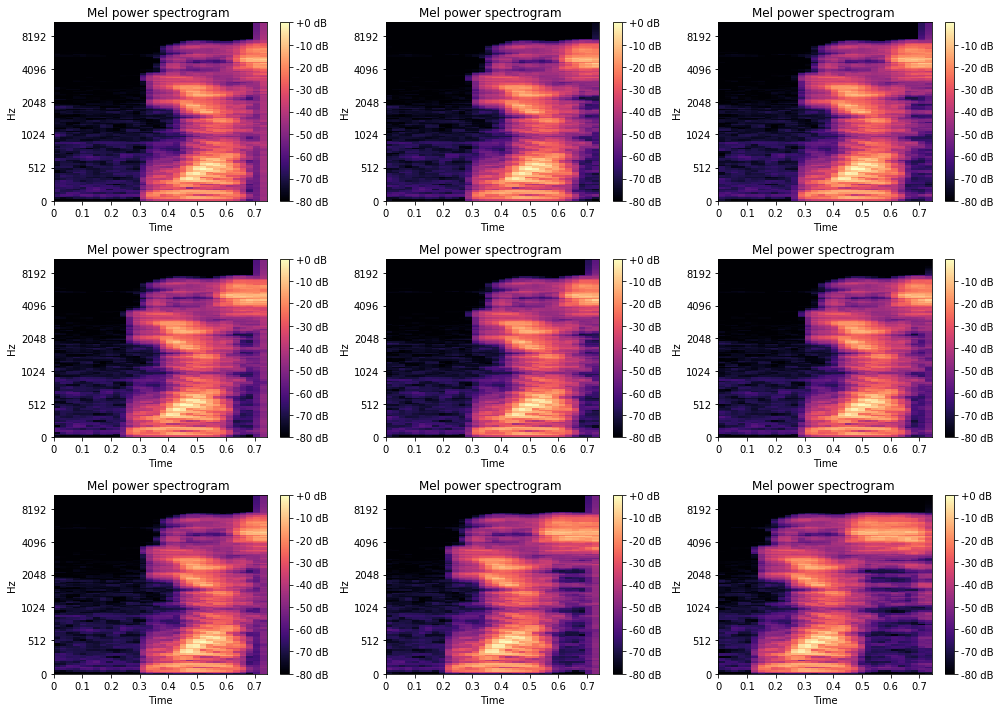

In [81]:
# Randomly selecting files belonging to same label 'yes' and plotting their mel power spectrogram 

fig = plt.figure(figsize=(14,10))
     

for i,rand_seed in enumerate(rand_int_list):
    # Make subplots
    plt.subplot(3,3,i+1)
    label_path=train_audio_path+label_for_visualization
    filename,samples, sample_rate, log_S=mel_specgram(label_path)
    librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title('Mel power spectrogram ')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

### 3.7 Waveform of same 9 files as above 

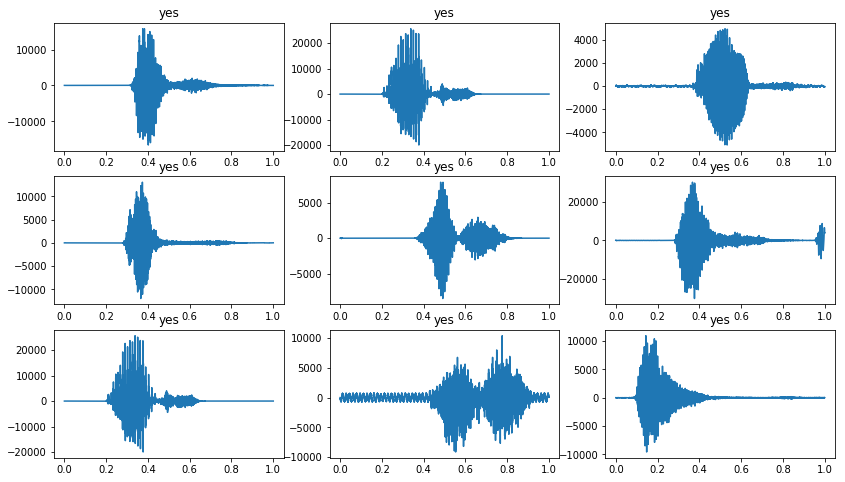

In [82]:
# Randomly selecting files belonging to same label and plotting their raw waveforms 

fig = plt.figure(figsize=(14,8))

for i,rand_seed in enumerate(rand_int_list):
    # Make subplots
    plt.subplot(3,3,i+1)
    label_path=train_audio_path+label_for_visualization
    filename,samples, sample_rate=readaudiofile(label_path,rand_seed=rand_seed)
    plt.title(label_for_visualization)
    plt.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

1. Raw Waveform: Tough to make out if these waveforms belong to same label though there are some similarities
2. Log Spectrogram: We can make out a pattern which looks like two vertical bands side by side. Better than looking at Raw Waveform
#### 3. Mel Power Spectrogram: These look remarkably similar. Might be better than Log Spectrograms as inputs to NN. Let us check some more words. 

### 3.8 Additional examination of Mel Power Spectrograms for other labels 

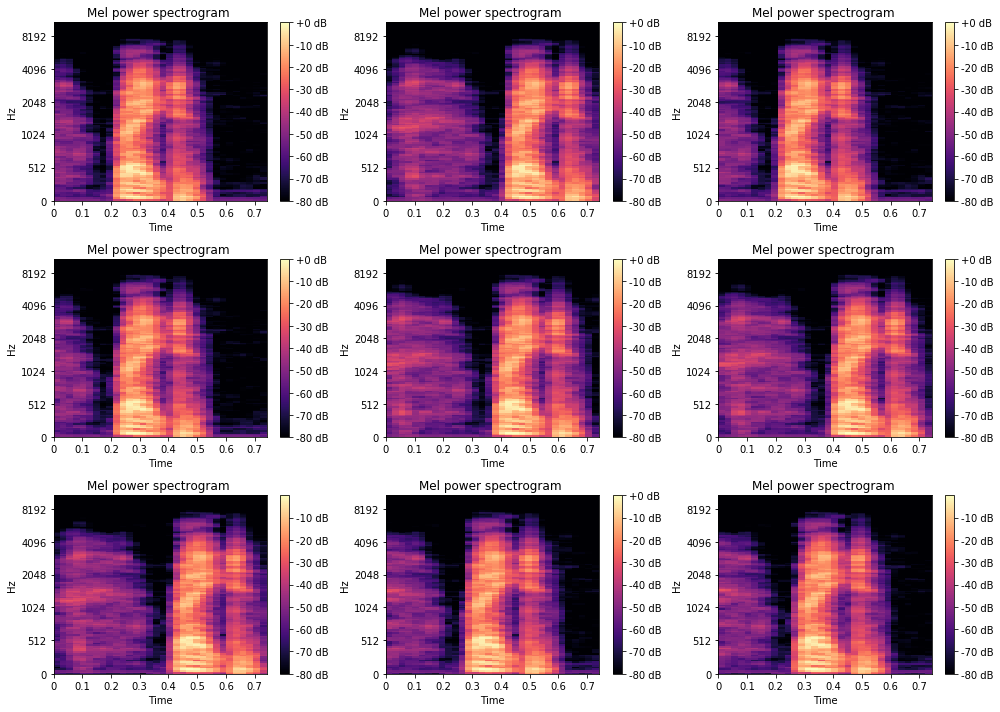

In [92]:
# Randomly selecting files belonging to same label 'yes' and plotting their mel power spectrogram 
# target_word_list=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
fig = plt.figure(figsize=(14,10))

rand_int_list=[]
for i in range(9):
    rand_int_list.append(random.randint(0,100))
label_for_visualization='right'        
     

for i,rand_seed in enumerate(rand_int_list):
    # Make subplots
    plt.subplot(3,3,i+1)
    label_path=train_audio_path+label_for_visualization
    filename,samples, sample_rate, log_S=mel_specgram(label_path)
    librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title('Mel power spectrogram ')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

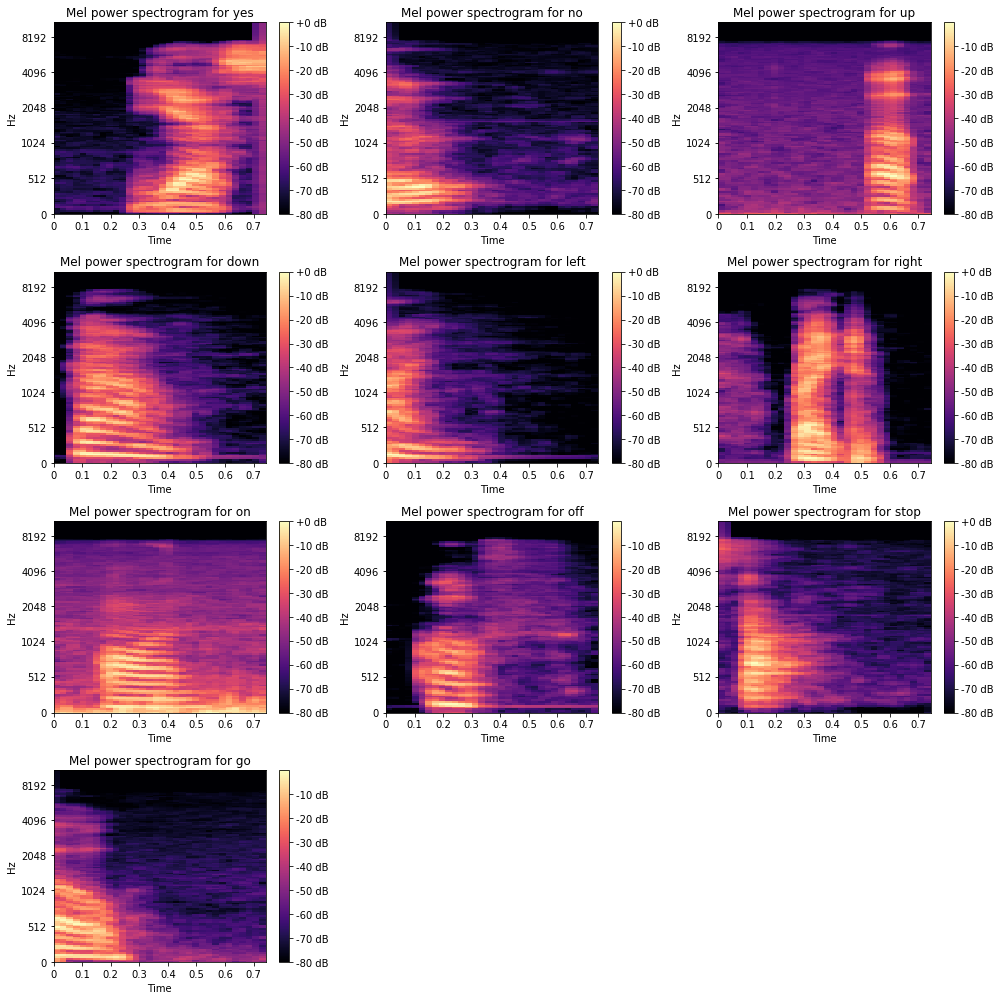

In [90]:
# Randomly selecting files from different folders of the target_word_list and plotting their log spectrogram 
fig = plt.figure(figsize=(14,14))

# for each of the samples
for i,label_for_visualization in enumerate(target_word_list):
    # Make subplots
    plt.subplot(4,3,i+1)
    label_path=train_audio_path+label_for_visualization
    filename,samples, sample_rate, log_S=mel_specgram(label_path)
    librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title('Mel power spectrogram for ' + label_for_visualization)
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()
    

#### Looking at the Mel Power Spectrogram, it seems like some words look completely different but some others look similar (like 'no' and 'go' for instance). It will be interesting to compare the result with log spectrogram and Mel power spectrogram. 

## 4. Resampling - Reducing size of dataset 

Have to resample data to 8000 Hz to see the effect. If things looks ok then use this smaller dataset to conduct analysis
Will update later tonight